In [ ]:
# This notebook performs a statistical analysis of mice doing the cloud of tones task
# stimulating the dopamine release in the tail of the striatum

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install git+file:///content/APE_paper
%cd APE_paper/doc/figures_notebooks

In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import exists
import urllib.request
import matplotlib.pylab as plt
import warnings
from ast import literal_eval

from APE_paper.utils import custom_functions as cuf
from APE_paper.utils.misc_utils import update_progress
from APE_paper.plot import make_figures
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# download data from server
dataset_name = 'DA-optostimulation_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
dao_df = pd.read_csv(dataset_path, index_col=0)

Data already in directory


In [14]:
# reconvert column to a diccionary
dao_df['FullGUI'] = [literal_eval(x) for x in dao_df.FullGUI]

In [3]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 225 # trials without stimulation, after some sampling

#### Generate **Figure 6C**

 - Progress: [##################--] 90.0%


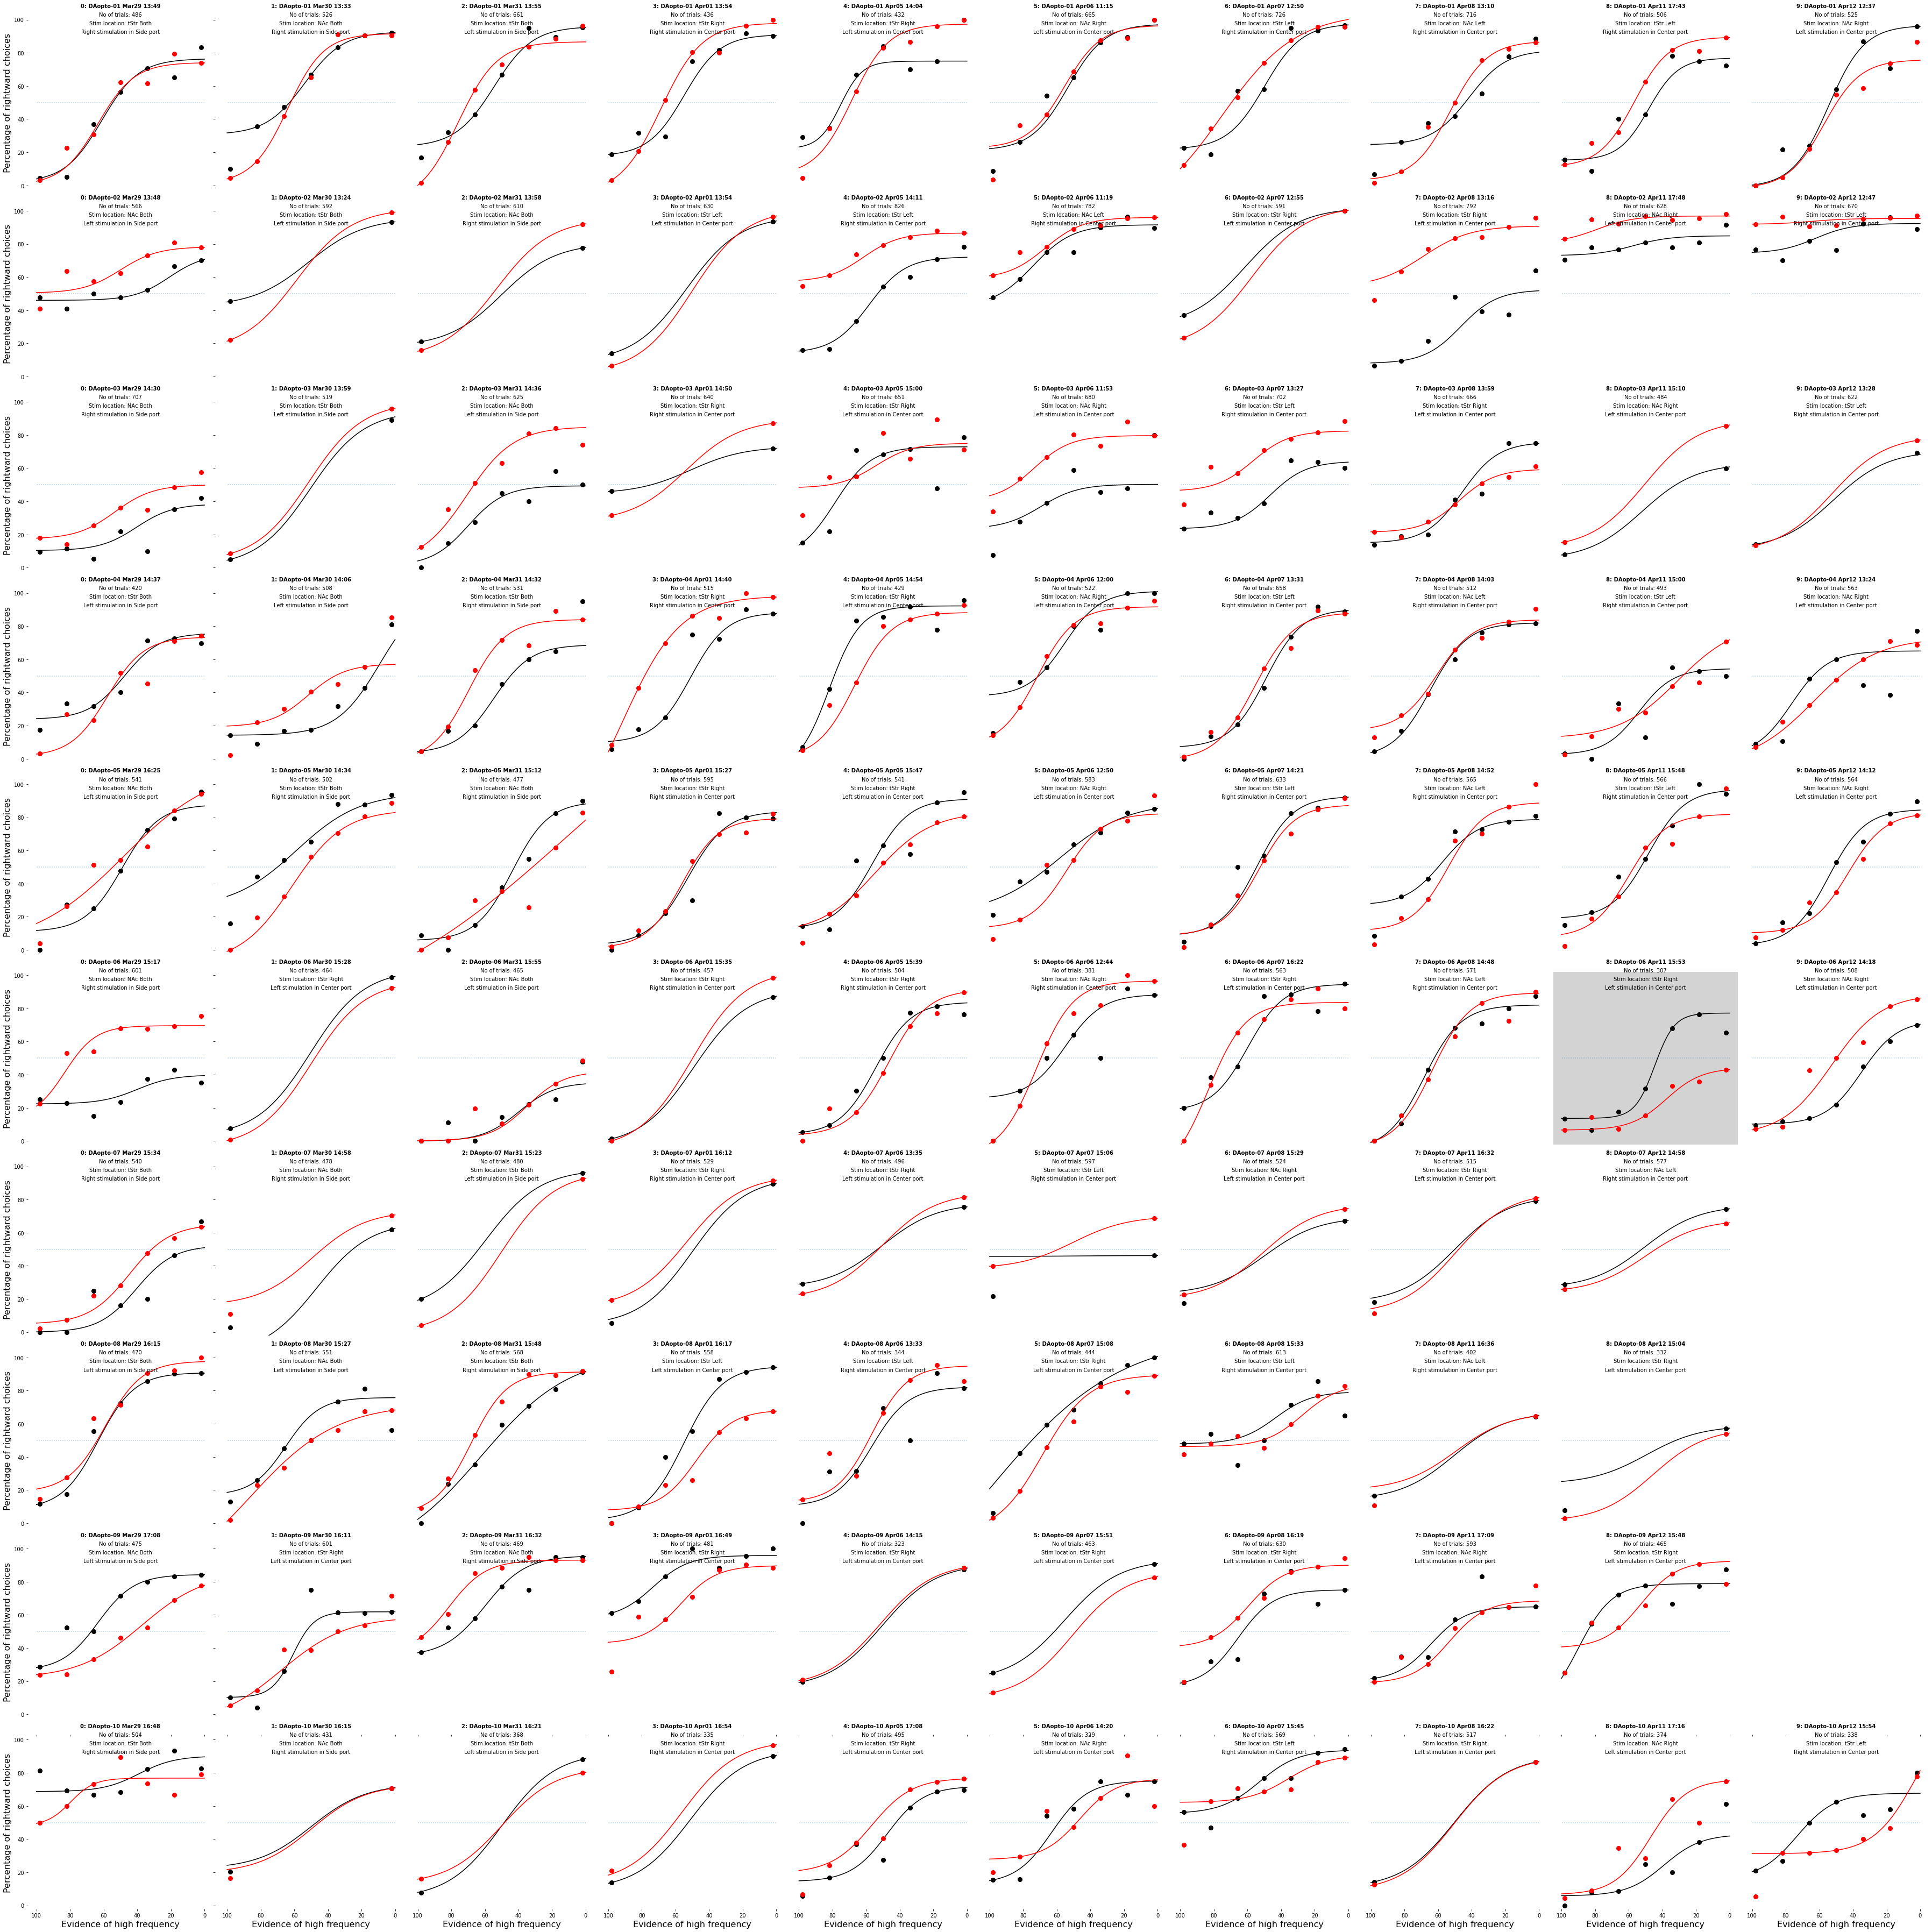

In [34]:
# see all the sessions done per animal
# highlight the session used as an example in the paper:
example_session = 'DAopto-06 Apr11 15:53'
fig = make_figures.make_figure_opto_da_all_mice(dao_df, ini_trials, ao_trials, example_session)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning_per-mouse.pdf',
#             transparent=True, bbox_inches='tight')


In [17]:
# Generate another dataset for every session containing information about the difference between
# the optostimulated trials and the normal ones, as well as random differences, calculated
# shuffling the trial indexes
n_times = 1000 # number of shuffles
opto_df = cuf.get_dopamine_optostimulation_differences_dataframe(dao_df, ini_trials,
                                                                 ao_trials, n_times)

 - Progress: [####################] 100.0%


In [35]:
# Subselect the dataframe based on some conditions
#### conditions 
# remove sessions in which initially the mouse is very bias
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation happens in contralateral trials
# this emulates the physiological conditions
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

opto_df_sel = opto_df[conditions].copy()

In [36]:
# We cannot repeat points. If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results)

opto_df_sel = cuf.merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel)

In [37]:
# remove NAc DAopto-03 as the fibers are not correctly placed DV
idx_to_remove = opto_df_sel[np.logical_and(opto_df_sel.AnimalID=='DAopto-03',
                           opto_df_sel.FiberArea=='NAc')].index

opto_df_sel.drop(idx_to_remove, inplace=True)

#### Generate **Figure 6D**

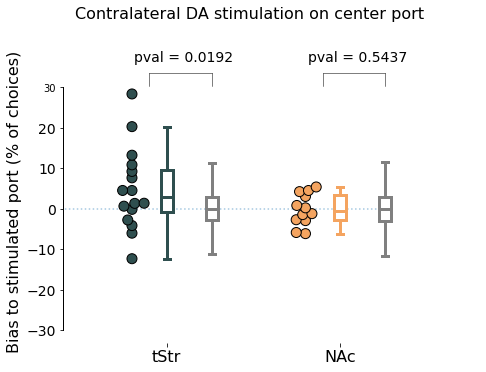

In [47]:
fig = make_figures.make_figure_opto_da_boxplots(opto_df_sel, hor = ['tStr', 'NAc'])
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'dopamine_optostimulation_centerport.pdf',
#             transparent=True, bbox_inches='tight')

#### Generate **Figure 6F**

In [45]:
# Subselect the dataframe based on some conditions
#### conditions 
# remove sessions in which initially the mouse is very bias
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation is not labeled as contralateral
# as the stimulation was bilateral
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

opto_df_sideport = opto_df[conditions].copy()

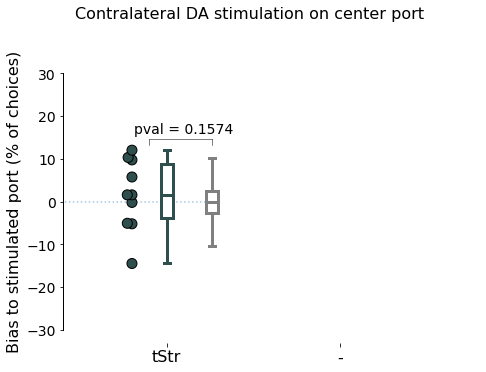

In [49]:
fig = make_figures.make_figure_opto_da_boxplots(opto_df_sideport, hor = ['tStr', '-'])
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'dopamine_optostimulation_sideport.pdf',
#             transparent=True, bbox_inches='tight')